In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from src.feature_engineering import (
    apply_feature_engineering,
    drop_all_zero_entries,
    choose_acc_ids,
)
import yaml

In [2]:
acc_config_path = Path("../config/acc_config.yaml")
with open(acc_config_path, "r") as yaml_file:
    acc_config = yaml.safe_load(yaml_file)

## Choose Account to have a look at

In [3]:
CATEGORY = "Investitionsausgaben"

In [4]:
# Replace with your actual data loading code
file_path = Path("../data/final/merged_double_digit.csv")
df = pd.read_csv(file_path, index_col=None, header=0)

# Convert 'Year' to a relative year
df["Year"] = df["Year"] - df["Year"].min()

# Sort dataframe and apply feature engineering
df = df.sort_values(by="Year")
df = apply_feature_engineering(df)
df = drop_all_zero_entries(df)
df = choose_acc_ids(df, acc_config.get(CATEGORY)) # Choose your account


In [5]:
# Calculate the percentage difference and handle division by zero
df['Percentage Difference'] = ((df['Budget y'] - df['Realized']) / df['Realized']).replace([np.inf, -np.inf], np.nan) * 100

In [6]:
# Clip the percentage difference to the 1% and 99% quantile
low_quantile = df['Percentage Difference'].quantile(0.01)
high_quantile = df['Percentage Difference'].quantile(0.99)

df = df[(df['Percentage Difference'] >= low_quantile) & (df['Percentage Difference'] <= high_quantile)]

In [7]:
df.tail()

,Year,Region,Acc-ID,Realized,Budget y,Budget y+1,Slack,Realized_1yr_lag,Realized_2yr_lag,Percentage Difference
10083,11,GL,50,19472.0,22260.0,24815.0,2788.0,17327.4,19498.9,14.317995
10085,11,GL,52,1064.3,1783.0,2212.0,718.7,1562.1,1185.6,67.527953
10086,11,GL,54,815.9,1990.0,1940.0,1174.1,3093.4,1589.1,143.902439
10088,11,GL,56,13530.7,14821.0,15099.0,1290.3,22447.5,14377.3,9.536092
10089,11,GL,57,8066.4,12027.0,17635.0,3960.6,7843.3,4169.7,49.099970


In [8]:
df.describe()

,Year,Acc-ID,Realized,Budget y,Budget y+1,Slack,Realized_1yr_lag,Realized_2yr_lag,Percentage Difference
count,1524.000000,1524.000000,1524.000000,1.524000e+03,1.524000e+03,1524.000000,1391.000000,1267.000000,1524.000000
mean,5.839239,54.042651,48825.646458,5.458636e+04,5.390329e+04,7678.046632,45931.257876,46380.265545,34.479779
std,3.307963,2.648136,102490.599970,1.144818e+05,1.156375e+05,31639.606800,101590.546832,101130.569527,183.757444
min,0.000000,50.000000,-19.788250,0.000000e+00,-1.500000e+03,-306912.816000,-89.798220,-89.798220,-100.000000
25%,3.000000,52.000000,2635.633333,1.670000e+03,1.300000e+03,0.000000,1329.066667,1306.616667,-12.239478
50%,6.000000,54.000000,10637.300000,1.159285e+04,1.078050e+04,952.987255,9215.323200,9070.800000,13.468419
75%,9.000000,56.000000,43762.549500,4.664323e+04,4.578322e+04,7245.178975,38036.715585,37147.000000,43.205413
max,11.000000,58.000000,994966.000000,1.086300e+06,1.086300e+06,322376.530390,994966.000000,994966.000000,2295.672007


In [9]:
highest_dev = df.sort_values(by='Percentage Difference', ascending=False).head(10)
highest_dev

,Year,Region,Acc-ID,Realized,Budget y,Budget y+1,Slack,Realized_1yr_lag,Realized_2yr_lag,Percentage Difference
3111,9,GE,55,709.61300,17000.0,17000.0,16290.38700,8185.321,12781.44320,2295.672007
3390,9,OW,54,75.30000,1650.0,1150.0,1574.70000,78.800,111.90000,2091.235060
8519,2,BL,54,1753.30000,38000.0,13750.0,36246.70000,3690.000,NaN,2067.341584
263,10,FR,55,850.00000,15600.0,10600.0,14750.00000,1500.000,5844.60000,1735.294118
222,10,BS,54,5379.65935,95710.0,75857.0,90330.34065,16223.380,33357.59718,1679.108932
6767,5,OW,54,74.00000,1300.0,2800.0,1226.00000,652.000,125.00000,1656.756757
4602,4,NE,54,472.00000,8085.0,7350.0,7613.00000,2072.000,NaN,1612.923729
8343,2,GL,54,9.20000,150.0,575.0,140.80000,10.000,0.00000,1530.434783
4391,4,SG,54,6544.70000,101152.0,35699.0,94607.30000,291288.000,0.00000,1445.555946
5876,1,UR,54,1064.20000,15582.7,15958.0,14518.50000,1063.000,NaN,1364.264236


## Aggregated Relative Difference

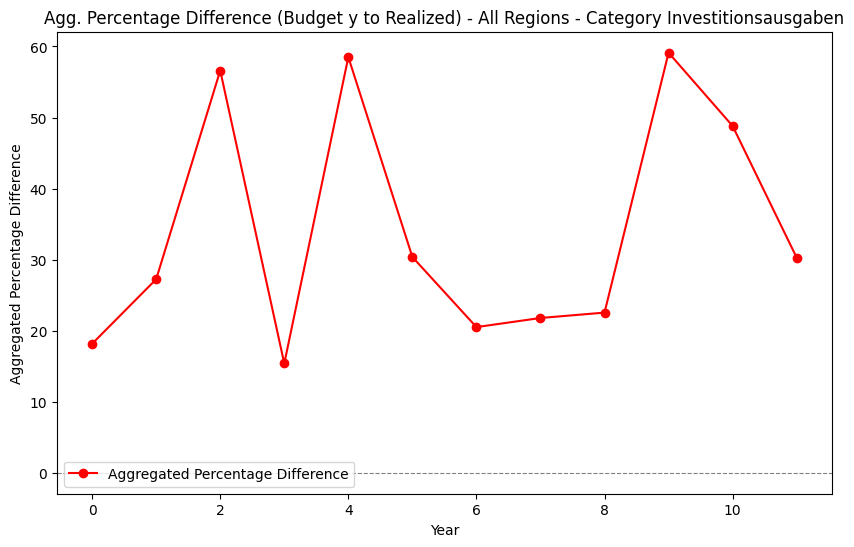

In [10]:
aggregated_data = df.groupby('Year')['Percentage Difference'].mean()

plt.figure(figsize=(10, 6))
plt.plot(aggregated_data.index, aggregated_data, marker='o', linestyle='-', color='red', label='Aggregated Percentage Difference')
plt.title(f'Agg. Percentage Difference (Budget y to Realized) - All Regions - Category {CATEGORY}')
plt.xlabel('Year')
plt.ylabel('Aggregated Percentage Difference')
plt.axhline(0, color='grey', lw=0.8, ls='--')  # Add a line at 0% difference for reference
plt.legend()
plt.show()


## Relative Difference per Region

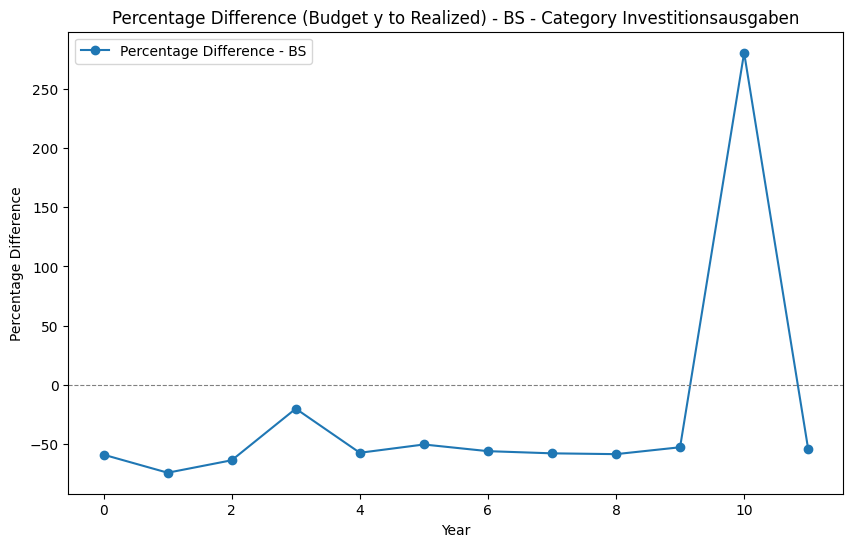

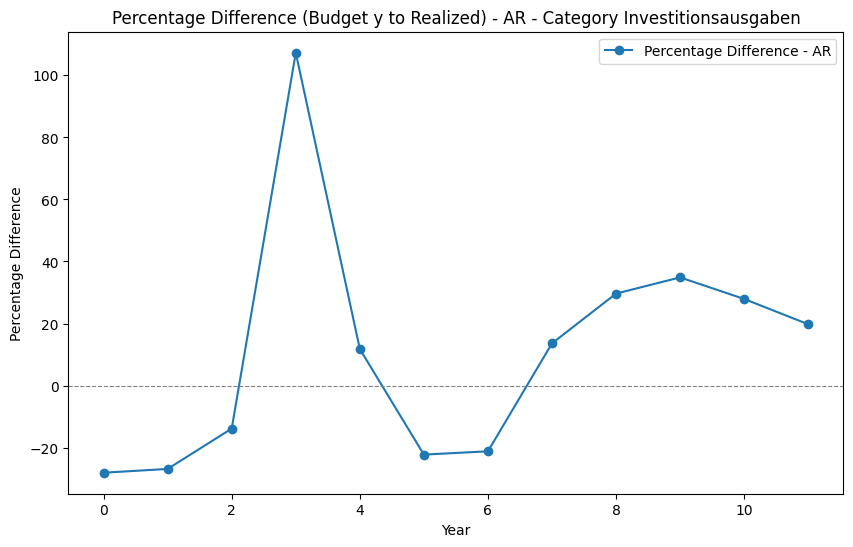

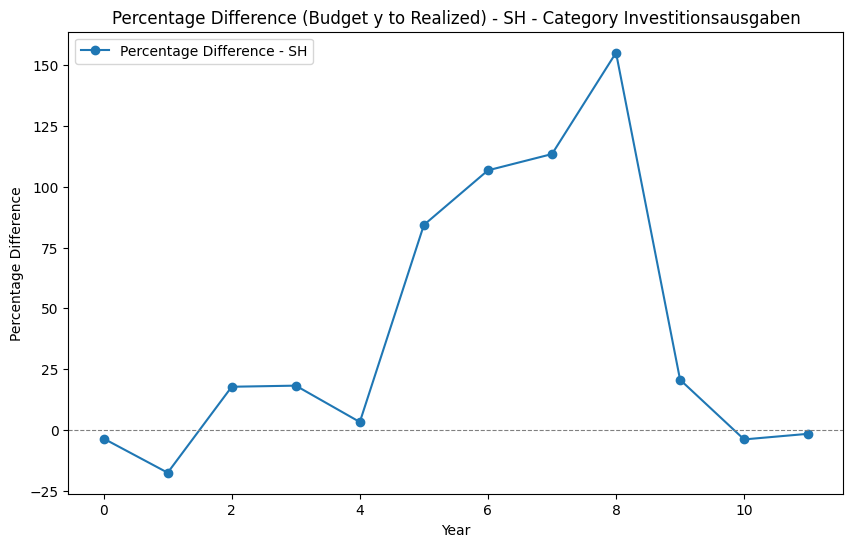

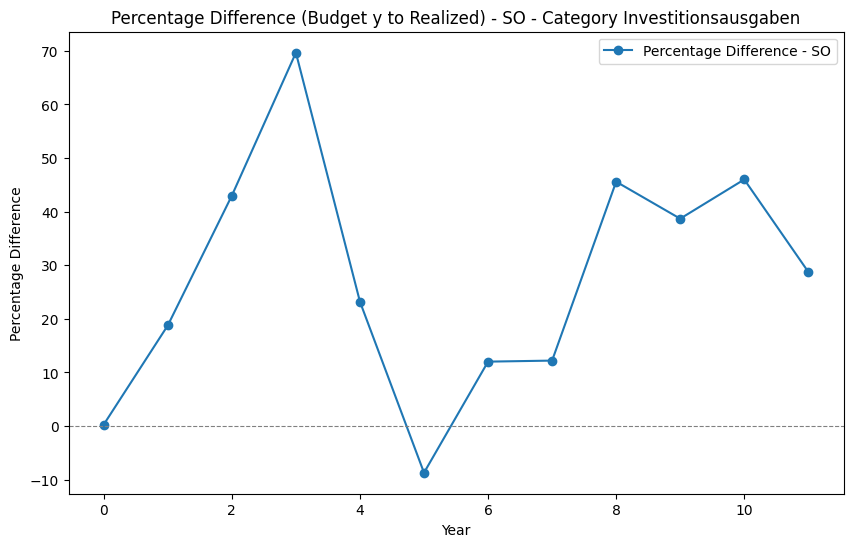

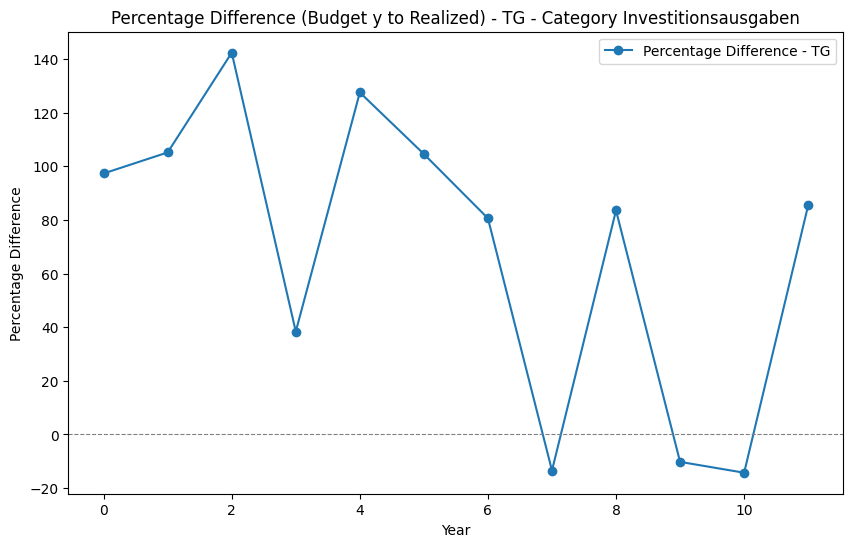

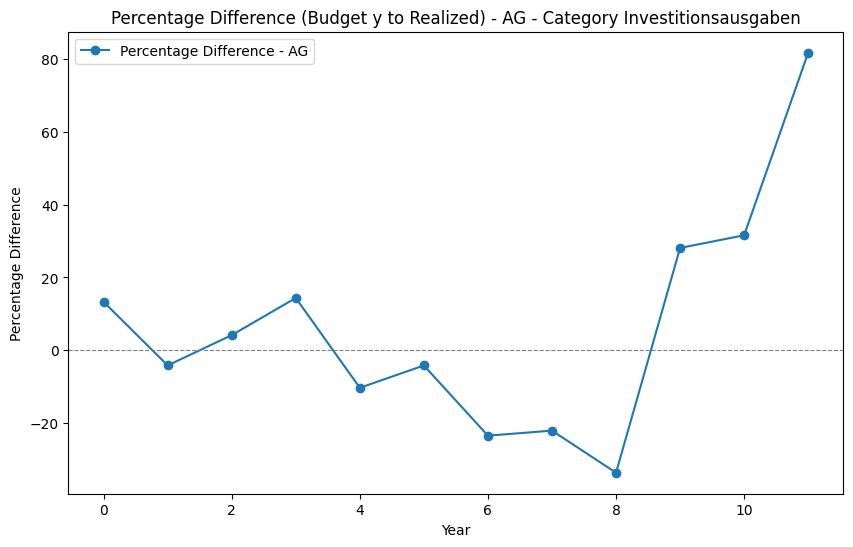

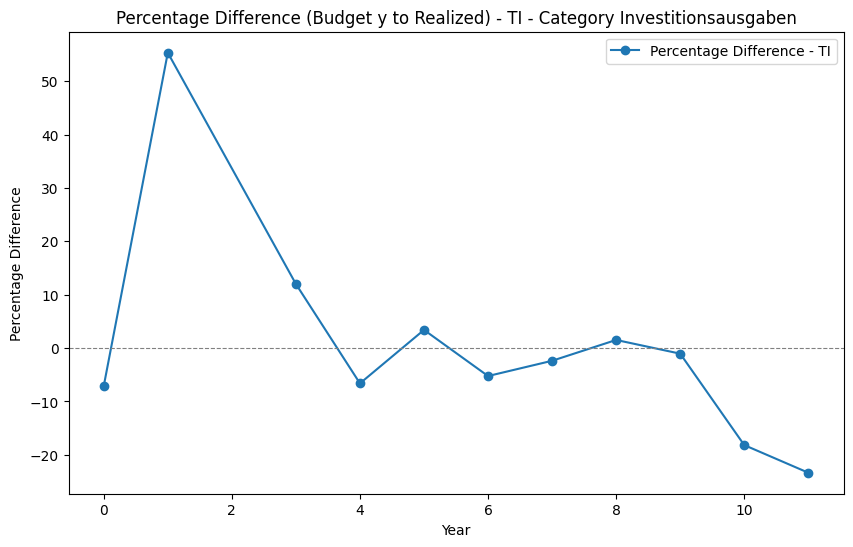

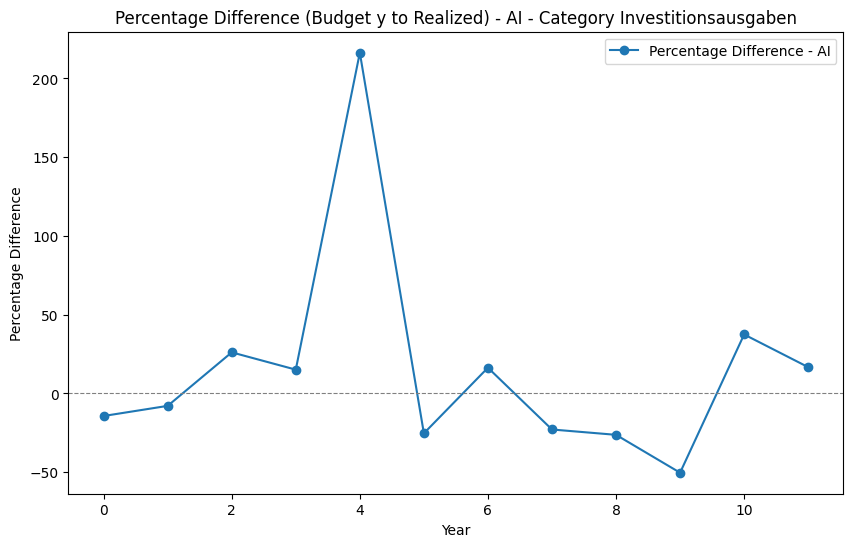

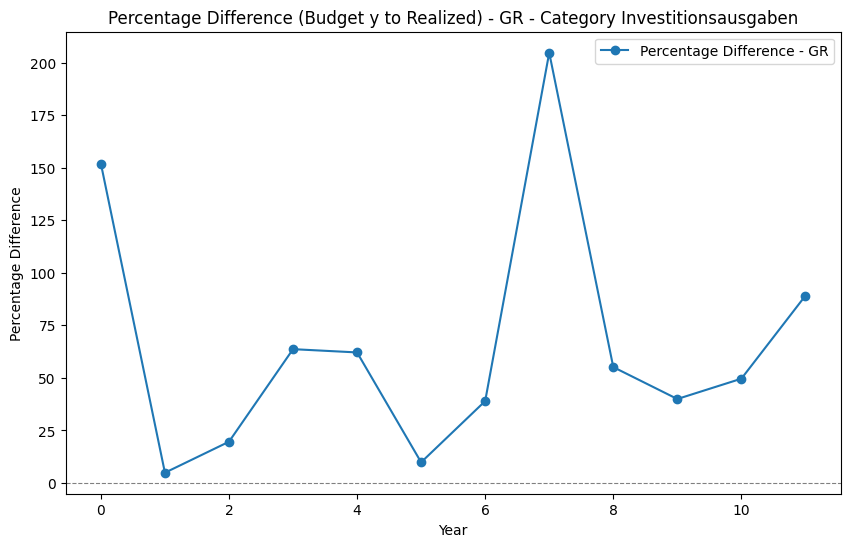

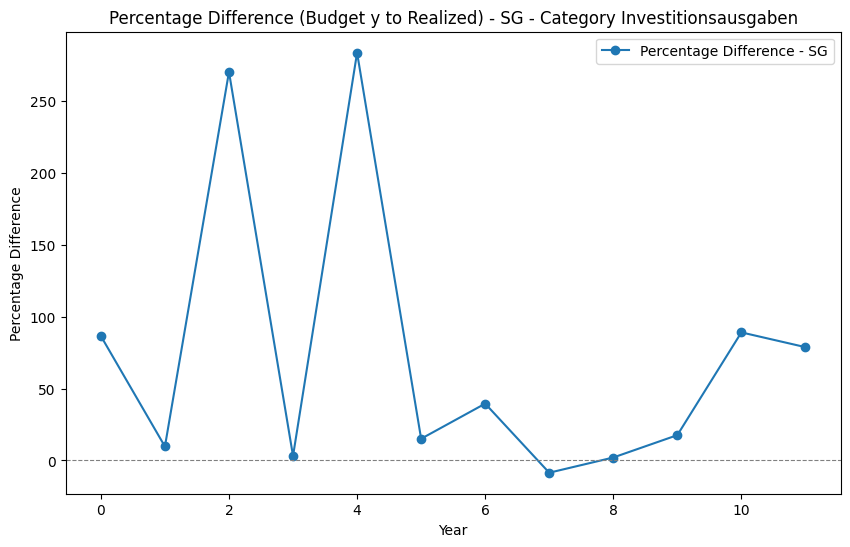

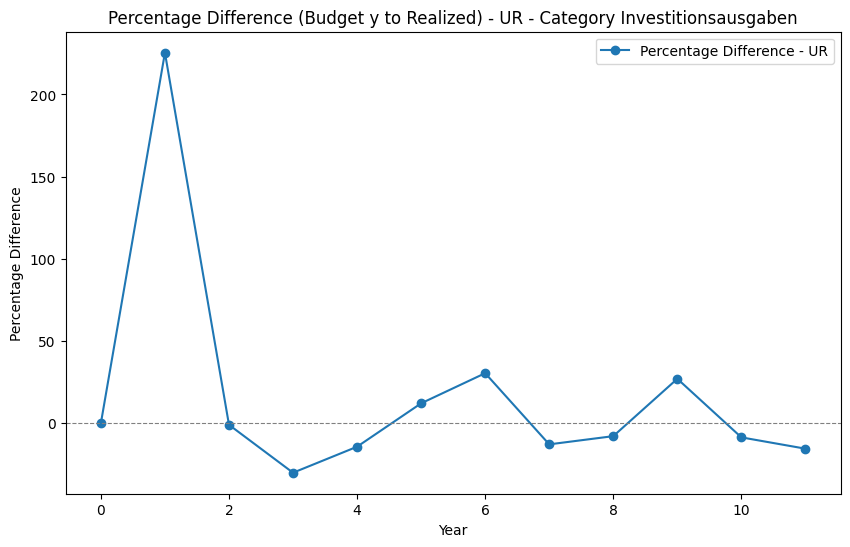

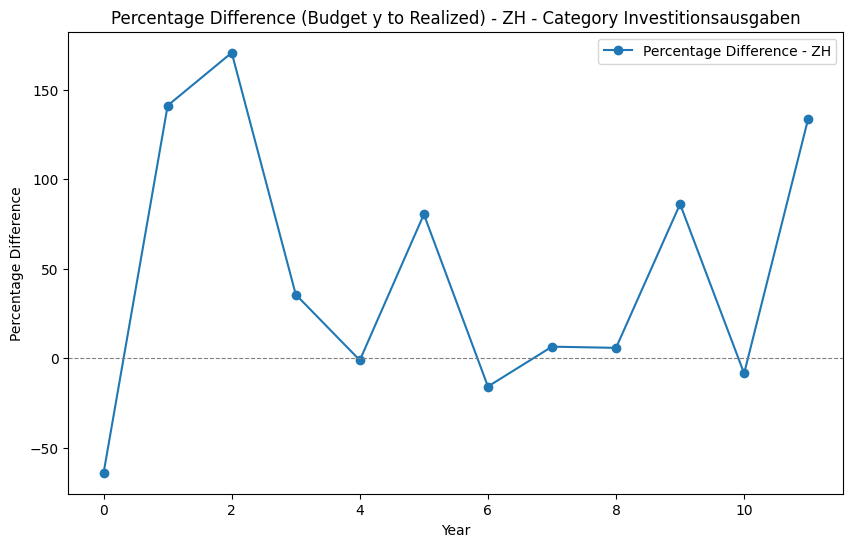

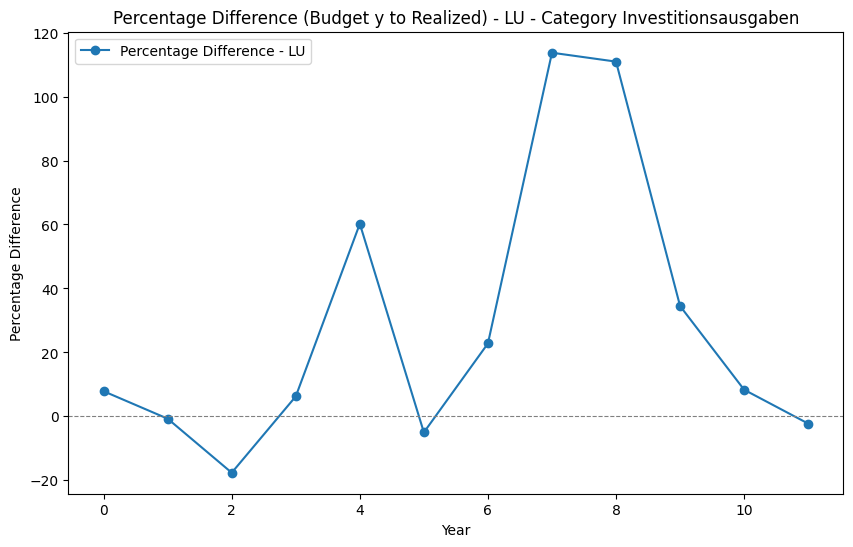

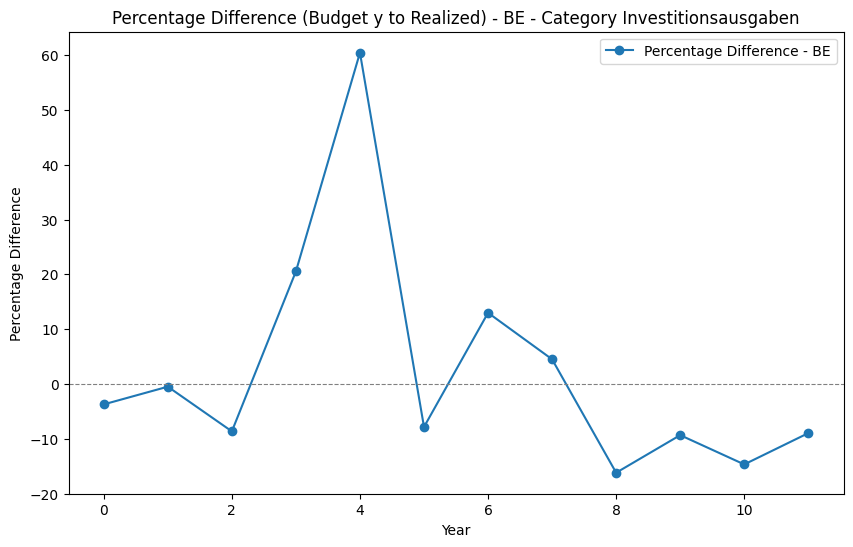

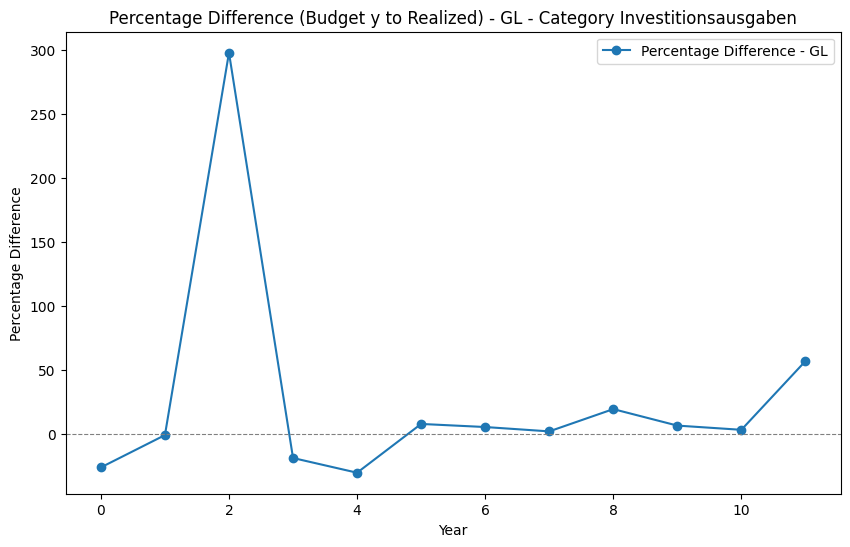

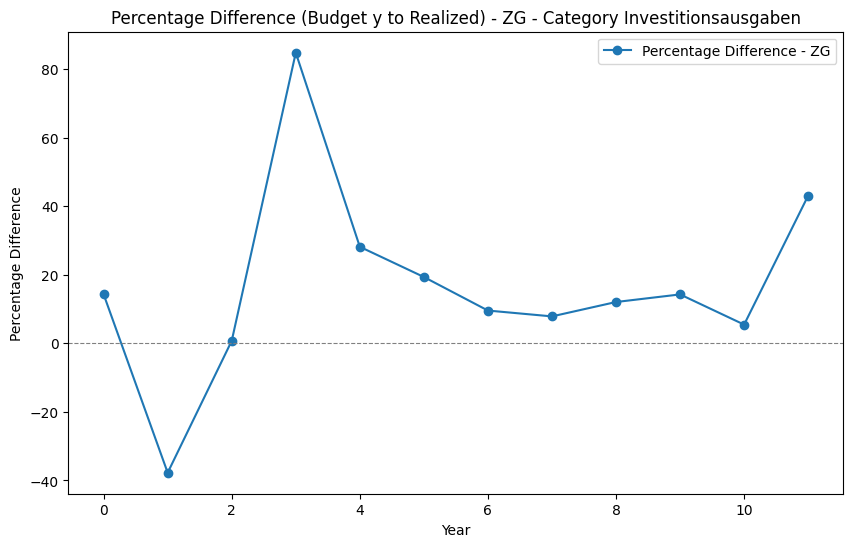

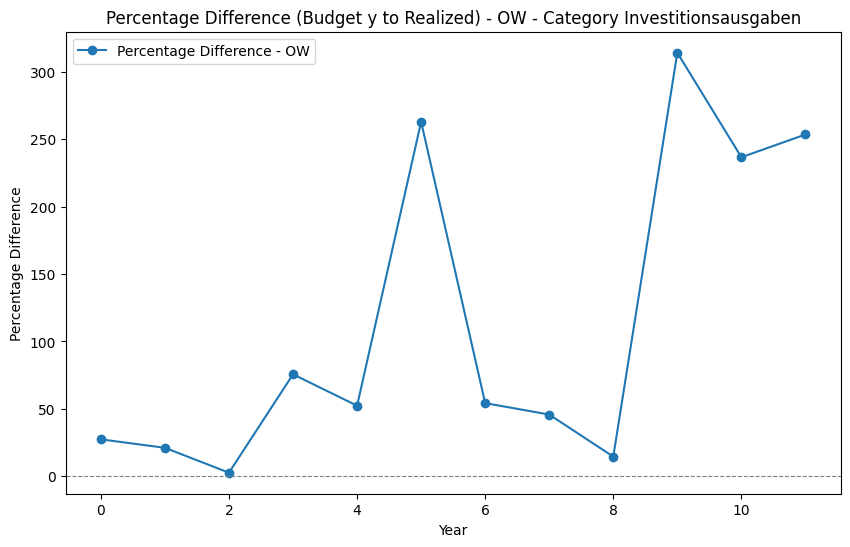

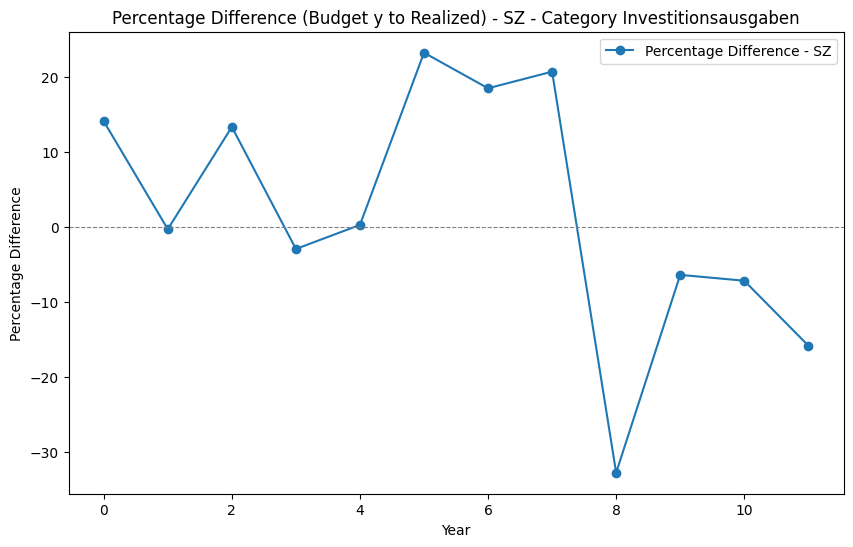

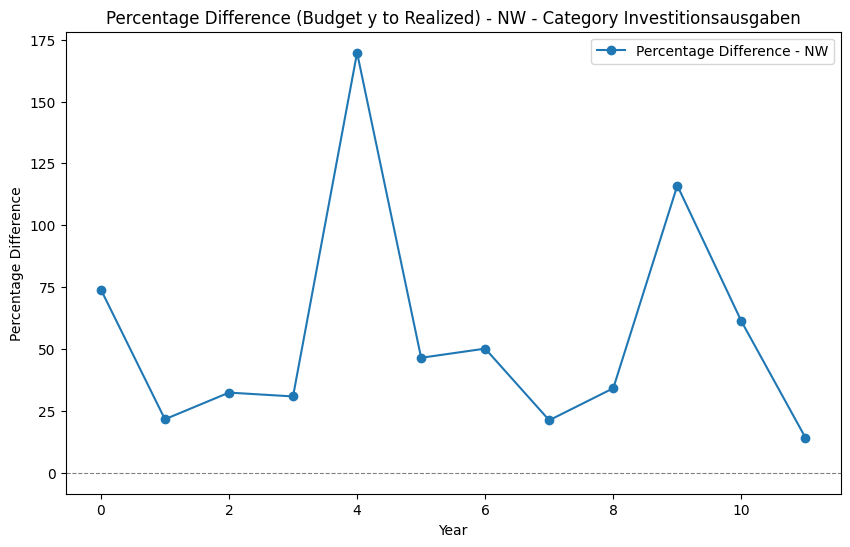

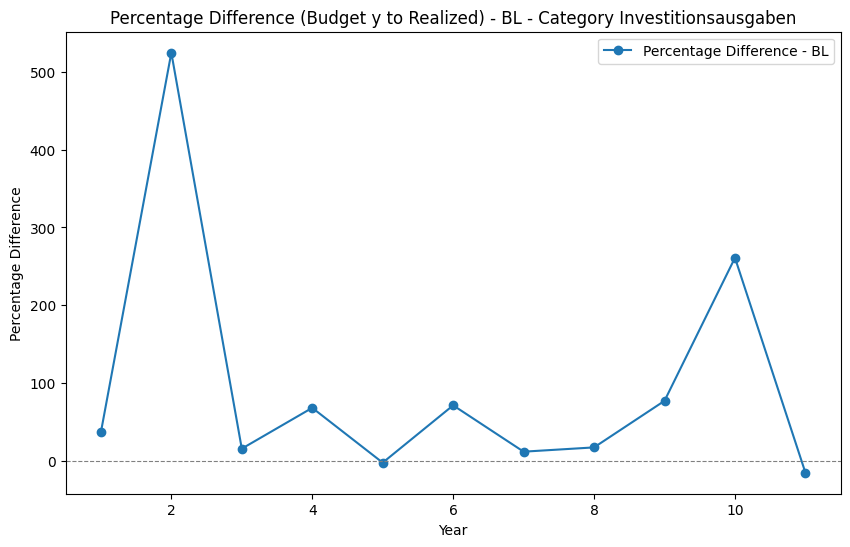

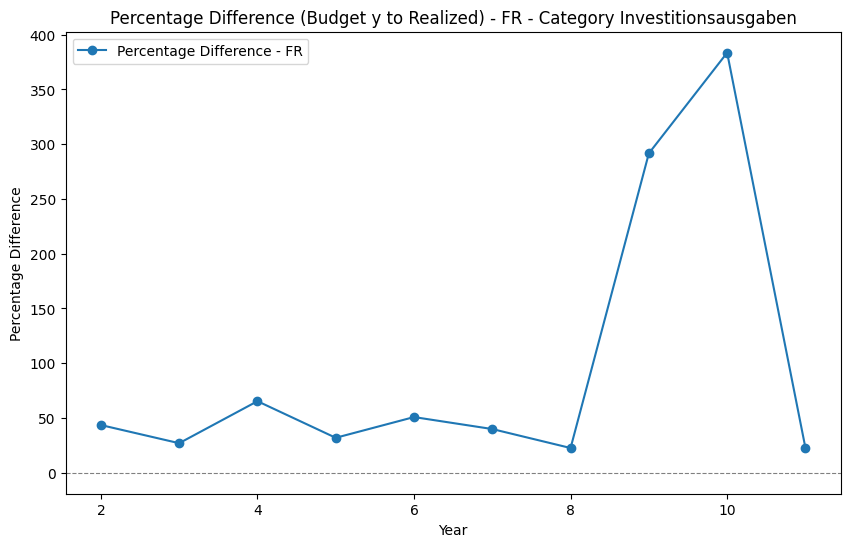

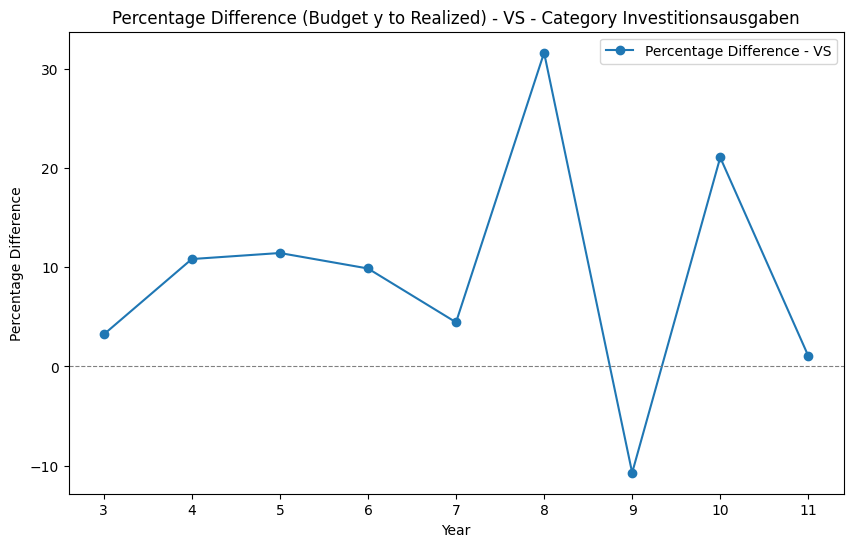

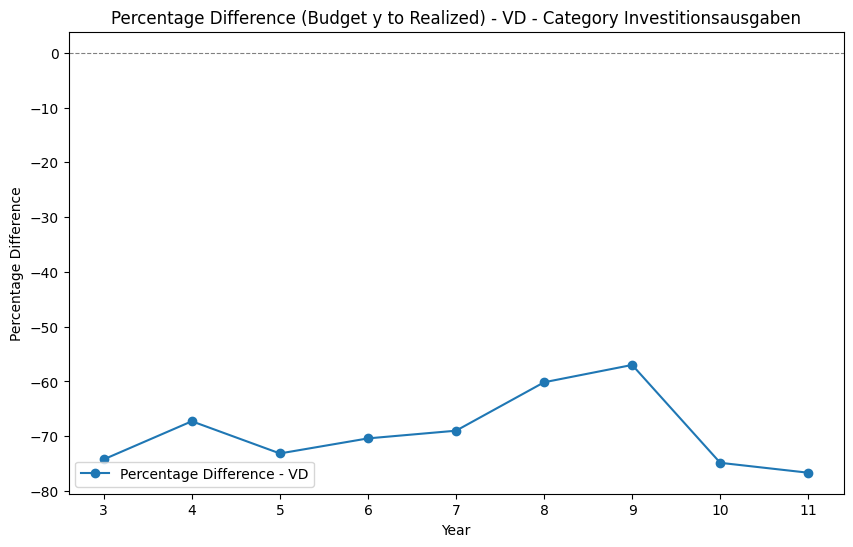

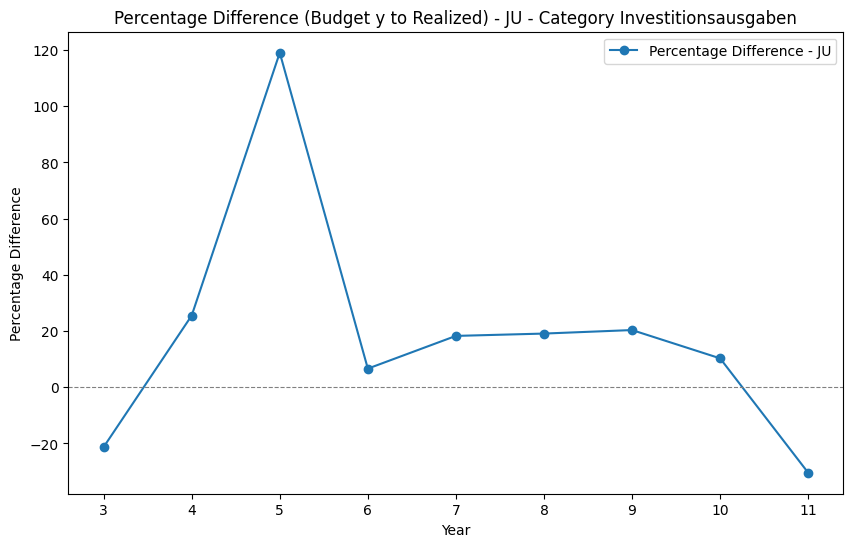

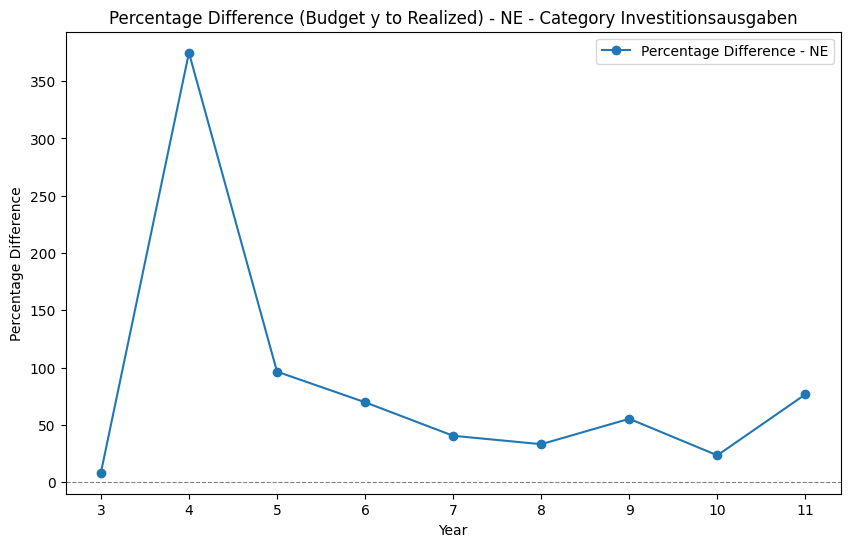

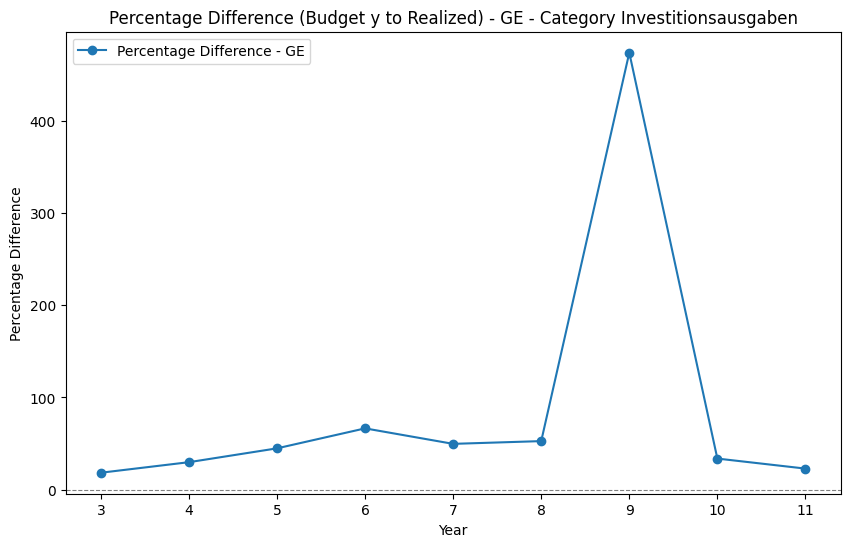

In [11]:
regions = df['Region'].unique()

for region in regions:
    region_data = df[df['Region'] == region].groupby('Year')['Percentage Difference'].mean()
    plt.figure(figsize=(10, 6))
    plt.plot(region_data.index, region_data, marker='o', linestyle='-', label=f'Percentage Difference - {region}')
    plt.title(f'Percentage Difference (Budget y to Realized) - {region} - Category {CATEGORY}')
    plt.xlabel('Year')
    plt.ylabel('Percentage Difference')
    plt.axhline(0, color='grey', lw=0.8, ls='--')  # Add a line at 0% difference for reference
    plt.legend()
    plt.show()
